In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch import nn
from torch.functional import F
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# Load the data
df = pd.read_csv('insurance.csv')
target = df.pop('expenses').to_numpy()
X_train, X_test, y_train, y_test = (torch.tensor(arr,dtype=torch.float).to(device) for arr in train_test_split(pd.get_dummies(df,dtype=int).values, target, test_size=0.2, random_state=0))

In [60]:
# Define the model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.max_log_y = torch.max(torch.log(y_train))
        self.sequnce = nn.Sequential(
            nn.Linear(11, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.sequnce(x)
    
    def preprocess(self, y):
        return torch.log(y) / self.max_log_y
    
    def postprocess(self, y):
        return torch.exp(y * self.max_log_y)
    
    def criterion(self, y_pred, y):
        return F.mse_loss(y_pred, self.preprocess(y)) + F.l1_loss(y_pred, self.preprocess(y))
    
    def evaluate(self, X, y):
        output = self.predict(X)
        return self.criterion(output, y).item(), F.l1_loss(output, y), F.mse_loss(output, y)
    
    def predict(self, X):
        return self.postprocess(self.forward(X).squeeze())
    
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100)

# Train the model
model.train()
for epoch in tqdm(range(10000)):
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = model.criterion(y_pred.squeeze(), y_train)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    if epoch % 1000 == 0:
        print(f'Epoch {epoch} loss: {loss.item()}, lr: {scheduler.get_last_lr()}')

# Evaluate the model
with torch.inference_mode():
    model.eval()
    y_pred = model(X_test)
    loss = model.criterion(y_pred.squeeze(), y_test)
    print(f'\nTest loss: {loss.item()}')


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 0 loss: 0.1369193196296692, lr: [0.001]
Epoch 1000 loss: 0.015476500615477562, lr: [0.0005]
Epoch 2000 loss: 0.014225678518414497, lr: [0.00025]
Epoch 3000 loss: 0.013588089495897293, lr: [0.000125]
Epoch 4000 loss: 0.013379662297666073, lr: [0.000125]
Epoch 5000 loss: 0.013333192095160484, lr: [0.000125]
Epoch 6000 loss: 0.012853140011429787, lr: [0.000125]
Epoch 7000 loss: 0.012653116136789322, lr: [6.25e-05]
Epoch 8000 loss: 0.01254922617226839, lr: [6.25e-05]
Epoch 9000 loss: 0.012498229742050171, lr: [3.125e-05]

Test loss: 0.011714011430740356


Testing set Mean Abs Error: 1854.44 expenses
You passed the challenge. Great job!


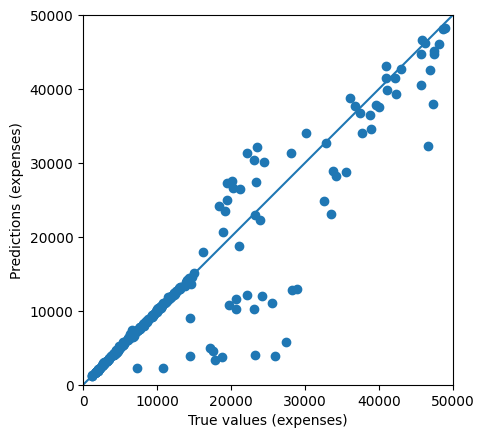

In [62]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(X_test, y_test)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test.cpu().detach().numpy(), test_predictions.cpu().detach().numpy())
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
